In [1]:
import os
import pandas as pd
import numpy as np

os.chdir("C:\\Users\\StuartWilson\\Documents\\Portfolio\\NEISS")

In [2]:
neiss = pd.read_csv('Data\\neiss.csv')
neiss = neiss.sample(frac=1)
print(neiss.shape)
print(neiss.columns)

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,12,13,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1841588, 27)
Index(['Unnamed: 0', 'CPSC_Case_Number', 'Treatment_Date', 'Age', 'Sex',
       'Race', 'Other_Race', 'Hispanic', 'Body_Part', 'Diagnosis',
       'Other_Diagnosis', 'Body_Part_2', 'Diagnosis_2', 'Other_Diagnosis_2',
       'Disposition', 'Location', 'Fire_Involvement', 'Alcohol', 'Drug',
       'Narrative', 'Stratum', 'PSU', 'Weight', 'Product', 'Product_2',
       'Product_3', 'Year'],
      dtype='object')


In [3]:
#show how many 'not recorded' in location column
neiss['Location'].value_counts(normalize=True)

Home                             0.439636
Not recorded                     0.283534
Place of recreation or sports    0.130473
Other public property            0.070278
School/Daycare                   0.053731
Street or highway                0.021715
Farm/ranch                       0.000347
Mobile/Manufactured home         0.000212
Industrial                       0.000074
Name: Location, dtype: float64

In [4]:
neiss['Narrative'].head(3)


1389505    12YOM CUT ARM WITH CHAINSAW WHILE HOLDING WOOD...
846058     16YOM-PT WAS PLAYING BASKETBALL WHEN HE FELT S...
1831150    73YOM TURNING LARGE PIECE OF WOOD ON LATHE, MA...
Name: Narrative, dtype: object

In [5]:
#remove unnecessary columns
neiss_clf = neiss[['Location', 'Narrative']]
neiss_clf.head()

Location  \
1389505                   Not recorded   
846058   Place of recreation or sports   
1831150                           Home   
106658           Other public property   
1153251                   Not recorded   

                                                 Narrative  
1389505  12YOM CUT ARM WITH CHAINSAW WHILE HOLDING WOOD...  
846058   16YOM-PT WAS PLAYING BASKETBALL WHEN HE FELT S...  
1831150  73YOM TURNING LARGE PIECE OF WOOD ON LATHE, MA...  
106658   91YOF FELL TO THE FLOOR AT THE NH SENT TO THE ...  
1153251  46YOM WAS DOING PUSH UPS WHEN HE STARTED FEELI...

In [6]:
#show value counts for locations after removing 'not recorded'
neiss_clf = neiss_clf.loc[~neiss['Location'].isin(['Not recorded', 'Farm/ranch',
                                           'Mobile/Manufactured home', 'Industrial']) == True]


In [7]:
#create indicator variables for locations

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(neiss_clf['Location'].unique()))
neiss_clf['Location_label'] = le.transform(neiss_clf['Location'])


In [8]:
# clean strings
# get rid of non alpha numeric
# fix the yof and yom
neiss_clf['Text'] = neiss_clf['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', ' ').str.lower()
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yof', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yom', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('y o f', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('y o m', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yf', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('ym', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yo f', ' yof ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yo m', ' yom ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('yr', ' yr ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('dx', ' dx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('sx', ' sx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('tx', ' tx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('fx', ' fx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace('hx', ' hx ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace(' wa s', ' was ')
neiss_clf['Text'] = neiss_clf['Text'].str.replace(' wa ', ' was ')


neiss_clf['Text'].head()

<ipython-input-8-d2ca7e906624>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  neiss_clf['Text'] = neiss_clf['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', ' ').str.lower()


846058     16 yom  pt was playing basketball when he felt...
1831150    73 yom  turning large piece of wood on lathe  ...
106658     91 yof  fell to the floor at the nh sent to th...
1237875    22mof fell off scooter and hit wall   dx   fx ...
1632224    neck str  30  yom  strained neck during martia...
Name: Text, dtype: object

In [9]:
#tokenize narrative
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
neiss_clf["Tokens"] = neiss_clf["Text"].apply(tokenizer.tokenize)


In [10]:
from tabulate import tabulate

table =  neiss_clf[612:615]
header = table.columns
print(tabulate(table, header, tablefmt="pipe"))

|         | Location                      | Narrative                                                                                                    |   Location_label | Text                                                                                                             | Tokens                                                                                                                                                                            |
|--------:|:------------------------------|:-------------------------------------------------------------------------------------------------------------|-----------------:|:-----------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1378518 | Place of recreation or sports | 13 YOM FELL PLAYIN

In [11]:
#take sample to save time fitting model
sample = neiss_clf.sample(500000)
sample['Location'].value_counts(normalize=True)

Home                             0.614412
Place of recreation or sports    0.182030
Other public property            0.098344
School/Daycare                   0.074998
Street or highway                0.030216
Name: Location, dtype: float64

In [12]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate    


def bow(token, data=sample):
    text = token.apply(lambda x: ' '.join(x))
    list_corpus = text.tolist()
    list_labels = data['Location_label'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, random_state=42,
                                                            test_size=0.2)
    count_vect = CountVectorizer()

    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.transform(X_test)
    return X_train, y_train, X_test, y_test, X_train_counts, X_test_counts

X_train, y_train, X_test, y_test, X_train_counts, X_test_counts = bow(sample['Tokens'])

scores = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average = 'weighted'),
           'recall' : make_scorer(recall_score, average = 'weighted'), 
           'f1_score' : make_scorer(f1_score, average = 'weighted')}

clf = SGDClassifier(random_state=42)
cv_results = cross_validate(clf, X=X_train_counts, y=y_train, scoring = scores, cv=10)

def get_metrics(results):  
    precision = np.mean(cv_results['test_precision'])           
    recall = np.mean(cv_results['test_recall'])
    f1 = np.mean(cv_results['test_f1_score'])
    accuracy = np.mean(cv_results['test_accuracy'])
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(cv_results)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.903, precision = 0.906, recall = 0.903, f1 = 0.898


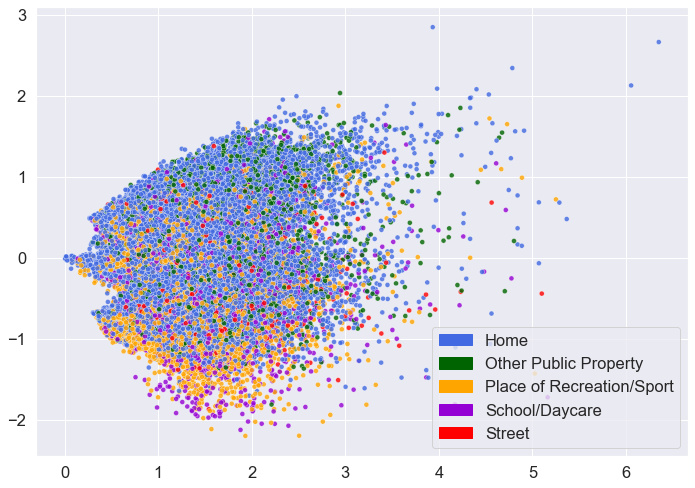

In [19]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plot_sample = neiss_clf.sample(50000)
X_train, y_train, X_test, y_test, X_train_counts, X_test_counts = bow(plot_sample['Tokens'], data=plot_sample)

truncate = TruncatedSVD(n_components=2)
truncated_x = truncate.fit_transform(X_train_counts)

sns.set(font_scale = 1.5)
a4_dims = (11.7, 8.27)
fig = plt.subplots(figsize=a4_dims)
colors = {0:'royalblue', 1:'darkgreen', 2:'orange', 3:'darkviolet', 4:'red'}
ax = sns.scatterplot(x=truncated_x[:, 0], y=truncated_x[:, 1], hue=y_train, palette=colors, s=25, alpha=0.8)
dot1 = mpatches.Patch(color='royalblue', label='Home')
dot2 = mpatches.Patch(color='darkgreen', label='Other Public Property')
dot3 = mpatches.Patch(color='orange', label='Place of Recreation/Sport')
dot4 = mpatches.Patch(color='darkviolet', label='School/Daycare')
dot5 = mpatches.Patch(color='red', label='Street')
ax.legend(handles=[dot1, dot2, dot3, dot4, dot5])
plt.savefig('Graphs\\truncated_simple.png', bbox_inches='tight')


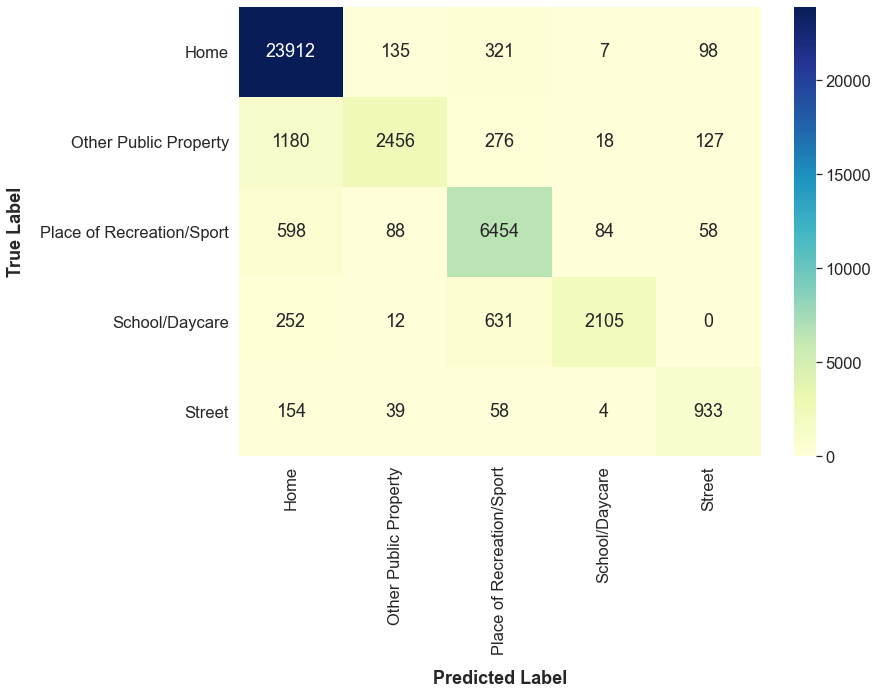

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

cm = confusion_matrix(y_train, y_pred)
labels = ['Home', 'Other Public Property', 'Place of Recreation/Sport', 'School/Daycare',
          'Street']
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

a4_dims = (11.7, 8.27)
fig = plt.subplots(figsize=a4_dims)
sns.set(font_scale = 1.5)
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
ax.set_ylabel('True Label', weight='bold', labelpad=15)
ax.set_xlabel('Predicted Label', weight='bold', labelpad=15)
plt.savefig('Graphs\\cm_simple.png', bbox_inches='tight')
